# Image Processing Lab
All  of  the  programming  assignments  are  to  be  done  in  Python  using  additional  libraries  specified  in  the  assignments.  There  are many  libraries  available,  some  of  which  we  will  be  using,  and  you  are  welcome  to  use  them  with  one  exception:  if  the  library  or  a  function  within  it  performs  the  specific  function  you  are  asked  to  code,  you  may  not  use  that  other  than  perhaps  as  a  reference  to  compare  against. All  of  the  code  you  submit  must  be  your  own. You are welcome to turn in a completed jupyter notebook.

The following code will load an image you can use for this lab. If needed make sure to install PIL using *pip install PIL* or *conda install PIL*.

## Pre-lab Notes
Since it is our first time working with color images, we need to be careful of a couple of things. Most RGB color images store each RGB value as an 8-bit number. This is fine for displaying images as shown below:

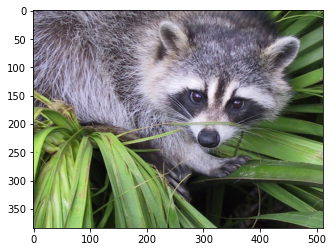

In [93]:
import matplotlib.pyplot as plt
import numpy as np
import pdb
racoon = plt.imread('racoon.jpg')
plt.imshow(racoon); plt.show()

This is fine for displaying, but becomes a problem once we try to do any image manipulations. We have to beware of overflow. For example, lets say we just want to add 20 to all of the RGB values.

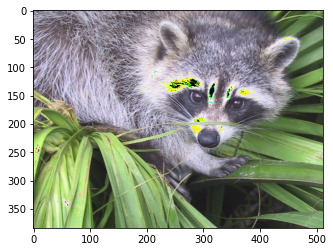

In [2]:
plt.imshow(racoon + 20)
plt.show()

Notice what happens near the white areas of the image. We only had 8-bits to respresent each RGB value (0 to 255). White areas will have values near 255. So when we add 20, the colors go crazy because values have overflowed (ex. 240 + 20 = 4).

You maybe tempted to try something like this:

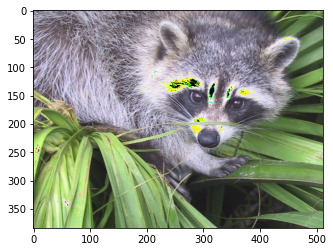

In [3]:
plt.imshow(np.minimum(racoon + 20, 255))
plt.show()

Notice that this still doesn't work because the overflow occurs before the maximum check.

The way to beat this problem is to convert the image into a higher bit representation, do the manipulations, then convert it back down to the 8-bit representation.

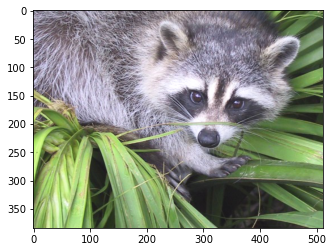

In [6]:
racoon_32 = np.array(racoon, dtype=np.int32)
racoon_32 = np.minimum(racoon_32 + 20, 255)
#racoon_8 = np.array(racoon_32, dtype=np.uint8)
plt.imshow(racoon_32)
#plt.imshow(racoon_8)
plt.show()

For convenience, we will leave all data in int32 representation. Then, we will simply define a function that converts the image back to 8-bit representation before plotting.

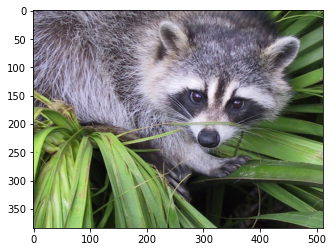

In [2]:
def plotImage(image, title=""):
    im = np.array(image, dtype=np.uint8)
    plt.imshow(im, vmin = 0, vmax = 255)
    plt.title(title)
    plt.show()

racoon = plt.imread('racoon.jpg')
racoon = np.array(racoon, dtype=np.int32)
plotImage(racoon)

You are welcome to use the function above for plotting your own color images.

In this lab, you will also need to be able to convert between RGB values and HSB values. We have provided function that allow you to easily go back and forth while staying in the 0-255 representation for images. You are welcome to use the functions below in this lab.

In [3]:
def toHSB(image):
    from matplotlib import colors
    temp = 255*colors.rgb_to_hsv(image/255.0)
    return temp.astype(np.int32)
    
def toRGB(image):
    from matplotlib import colors
    temp = 255*colors.hsv_to_rgb(image/255.0)
    return temp.astype(np.int32)

Now that you have that understanding, you are ready to start the lab.

Implement each of the following functions. Use the provided test cases to test your functions.

## Function 1: Convert to grayscale
Takes in a color image and returns a grayscale image using the following formula: Gray = 0.299 Red + 0.587 Green + 0.114 Blue

In [10]:
racoon.shape

(384, 512, 3)

In [118]:
def toGrayScale(image):
    new_image = image.copy()
    
    new_image = image[:,:,0] * 0.299 + image[:,:,1] * 0.587 + image[:,:,2] * 0.114
    
    # For a 3 dimensional grayscale image
#     for i in range(image.shape[0]):
#         for j in range(image.shape[1]):
#             total = np.minimum(image[i,j,0] * .299 + image[i,j,1] * .587 + image[i,j,2] * .114, 255)
#             new_image[i][j][0], new_image[i][j][1], new_image[i][j][2] = total, total, total 
    
#     for i in range(image.shape[0]):
#         for j in range(image.shape[1]):
#             # Avg the three pixels RGB
#             grey_val = (image[i][j][0] + image[i][j][1] + image[i][j][2])//3
#             image[i][j][0], image[i][j][1], image[i][j][2] = grey_val, grey_val, grey_val
    
    return new_image


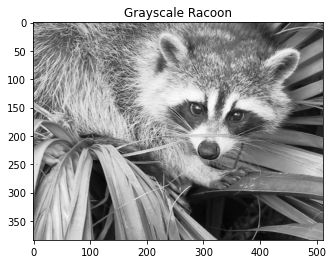

(384, 512)


In [133]:
# Test Case
gray_racoon = toGrayScale(racoon)
plt.imshow(gray_racoon,cmap="Greys_r",vmin=0,vmax=255)
plt.title("Grayscale Racoon")
plt.show()
print(gray_racoon.shape)

## Function 2: Brightness Adjustment
Takes in a color image and returns the brightened version of that image according to a passed in parameter. Use a max image value of 255.

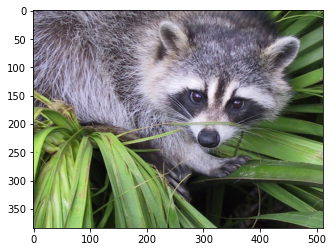

In [11]:
def brightAdjust(image,c):
    im = toHSB(image) # Convert to HSB
    #print(im[0,0,0])
    #pdb.set_trace()
    sat_layer = im[:,:,2]
    sat_layer = sat_layer + c
    if c < 0:
        new_sat = np.maximum(sat_layer, 0)
    else:
        new_sat = np.minimum(sat_layer, 255)
    #pdb.set_trace()
    im[:,:,2] = new_sat
    
    return toRGB(im)



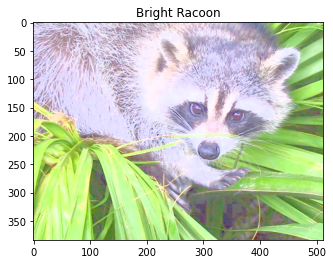

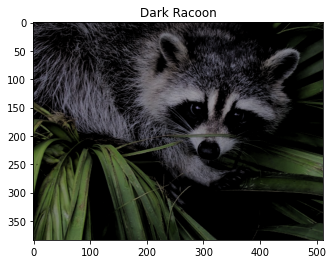

In [12]:
# Test Case
bright_racoon = brightAdjust(racoon,100)
plotImage(bright_racoon, "Bright Racoon")
dark_racoon = brightAdjust(racoon,-100)
plotImage(dark_racoon, "Dark Racoon")

## Function 3: Contrast Adjustment
Takes in a color image and returns the contrasted version of that image according to a passed in parameter. Use a max image value of 255.

Also, rather than a straight linear operation, we will use a mapping similar to what Photoshop does. In particular, the contrast will be in the range [-100,100] where 0 denotes no change, -100 denotes complete loss of contrast, and 100 denotes maximum enhancement (8x multiplier). If *c* is the contrast parameter, then the level operation applied is:

$$s = \left(\frac{c+100}{100}\right)^4 (r-128) + 128$$

Make sure you work in floating point, not integers. Integer division would not be very acurate.

In [107]:
def contrastAdjust(image, c):
    # Faster method
    new_image = image.copy()
    new_image = toHSB(new_image)
    new_image[:,:,2] = ((c + 100)/100)**4 * (new_image[:,:,2] - 128) + 128
    new_image = toRGB(new_image)
    new_image[np.where(new_image > 255)] = 255
    new_image[np.where(new_image < 0)] = 0
    return new_image

#     im = toHSB(image)
#     im = np.array(im, dtype=np.float32)
    
#     luminence_lay = im[:,:,1]
#     new_img = (((c + 100)/100)**4)*(luminence_lay - 128) + 128
#     for i in range(new_img.shape[0]):
#         for j in range(new_img.shape[1]):
#             if new_img[i,j] < 0:
#                 new_img[i,j] = 0
#             elif new_img[i,j] > 255:
#                 new_img[i,j] = 255
#     #Add new layer back to image
#     im[:,:,1] = new_img
    


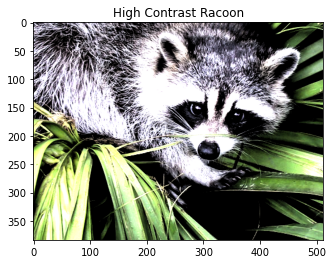

In [108]:
contrast_racoon = contrastAdjust(racoon,30)
plotImage(contrast_racoon, "High Contrast Racoon")

## Function 4: Image Blending
Takes in 2 color images of the same size. Given an alpha value it returns the blended image according to the alpha value. Note that your alpha value can be a single number or a mask image of the same size. The alpha values will be between 0 and 1.

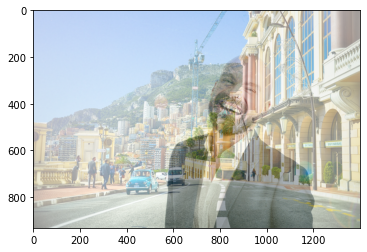

In [74]:
man = plt.imread("man.jpg")
city = plt.imread("city.jpg")
man =  np.minimum(.5 * man + .5 *city, 255)
plotImage(man)

In [4]:
def alphaBlend(image1, image2, alpha = .5):
    new_image = np.minimum(alpha * image1 + (1 - alpha) * image2, 255)
    return new_image



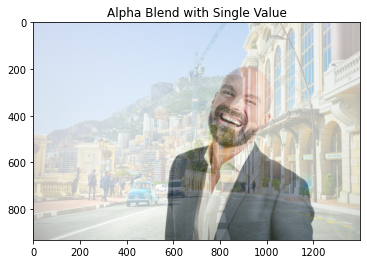

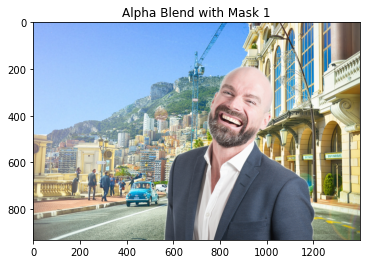

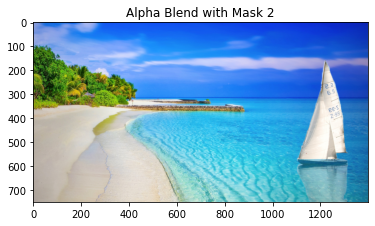

In [80]:
# Test Cases
man = plt.imread("man.jpg")
city = plt.imread("city.jpg")
blended = alphaBlend(man, city, .7)
plotImage(blended, "Alpha Blend with Single Value")

mask1 = plt.imread("alphamask1.jpg")/255.0
blended1 = alphaBlend(man, city, mask1)
plotImage(blended1, "Alpha Blend with Mask 1")

beach = plt.imread("beach.jpg")
boat = plt.imread("boat.jpg")
mask2 = plt.imread("alphamask2.jpg")/255.0
blended2 = alphaBlend(boat, beach, mask2)
plotImage(blended2, "Alpha Blend with Mask 2")

## Function 5: Cross Dissolve

Takes in 2 color images of the same size. Returns an array of alpha blend of those two images, where the first picture is an alpha value of 1, the last picture is an alpha value of 0, and the middle pictures slowly decrease until reaching zero. Allow the user to specify the number of steps in the cross dissolve. You can then feed this array into our animation function to view the cross dissolve.

In [18]:
def crossDissolve(image1, image2, numsteps = 10):
    img_arr = []
    for i in range(1, numsteps):
        img_arr.append(alphaBlend(image1, image2, i/numsteps))
        #pdb.set_trace()
        #plotImage(img_arr[i-1])
    return img_arr



<IPython.core.display.Javascript object>


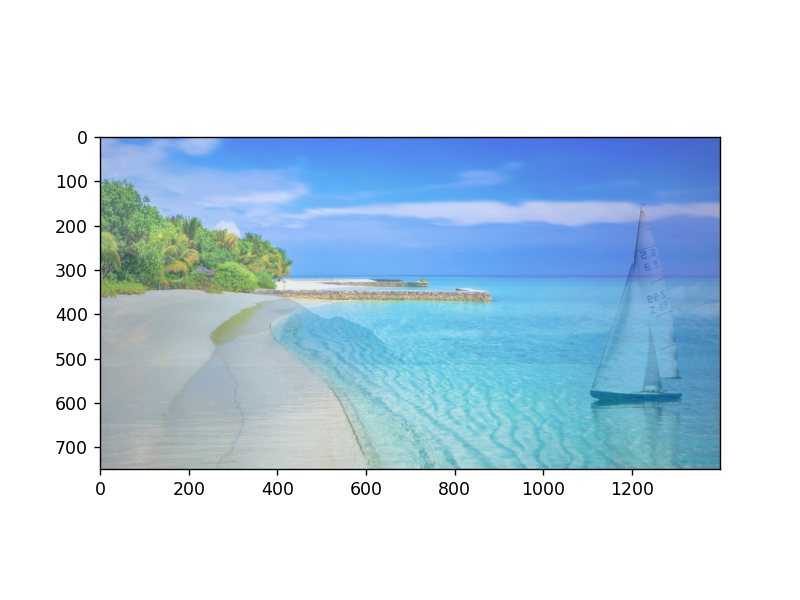

In [19]:
#Test Case
import matplotlib.animation as animation
%matplotlib notebook

beach = plt.imread("beach.jpg")
boat = plt.imread("boat.jpg")
dis = crossDissolve(beach, boat)

fig = plt.figure()
ims = []
for im in dis:
    im = np.array(im, dtype=np.uint8)
    result = plt.imshow(im, vmin=0, vmax=255, animated=True)
    ims.append([result])

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True)
plt.show()

Because we are working in a notebook, this may not display properly. If necessary, plot the individual pictures to verify that the cross dissolve is working. Also, run the following line of code once you are done to return back to normal plotting functions.

In [20]:
%matplotlib inline

## Function 6: Uniform Blurring
Takes in a grayscale image and returns a corresponding result that has been blurred (spatially filtered) using a uniform averaging. Allow the user to specify the size of the kernel (ex. size=3 would give a 3x3 kernel). You can ignore the edge pixels. (Hint: np.sum() may be useful)

In [69]:
test = 7//2
test

3

In [131]:
def blur(image,size=3):
    # Create a result buffer so that you don't affect the original image
    n_rows = image.shape[0]
    n_cols = image.shape[1]
    radius = int(size // 2)
    result = np.zeros(image.shape)
    for i in range(0, n_rows):
        for j in range(0, n_cols):
            top = i - radius
            bottom = i + radius + 1
            left = j - radius
            right = j + radius + 1
            if top < 0: # out of the top
                top = 0
            if bottom >= n_rows: # off the bottom side
                bottom = n_rows - 1
            if left < 0: # off the left
                left = 0
            if right >= n_cols: # off the right
                right = n_cols - 1
                
            square_slice = image[top:bottom, left:right]
            avg = square_slice.sum() // size**2
            result[i,j] = avg
    return result

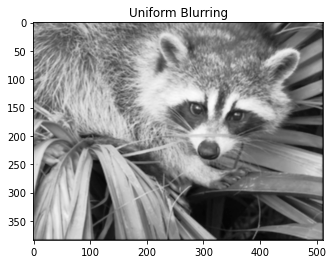

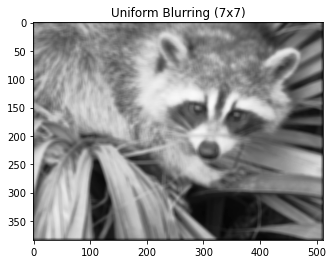

In [132]:
racoon = plt.imread('racoon.jpg')
racoon = np.array(racoon, dtype=np.int32)

# Test Cases
gray_racoon = toGrayScale(racoon)
blur_racoon = blur(gray_racoon)
plt.imshow(blur_racoon,cmap="Greys_r",vmin=0,vmax=255); plt.title("Uniform Blurring")
plt.show()

blur_racoon2 = blur(gray_racoon, 7)
plt.imshow(blur_racoon2,cmap="Greys_r",vmin=0,vmax=255); plt.title("Uniform Blurring (7x7)")
plt.show()

## Function 7: Median Filter
Takes in a grayscale image and returns a corresponding result that has been median filtered. Allow the user to specify the size of the kernel (ex. size=3 would give a 3x3 kernel). You can ignore the edge pixels.

In [134]:
def medianFilter(image,size=3):
    n_rows = image.shape[0]
    n_cols = image.shape[1]
    radius = int(size // 2)
    result = np.zeros(image.shape)
    for i in range(0, n_rows):
        for j in range(0, n_cols):
            top = i - radius
            bottom = i + radius + 1
            left = j - radius
            right = j + radius + 1
            if top < 0: # out of the top
                top = 0
            if bottom >= n_rows: # off the bottom side
                bottom = n_rows - 1
            if left < 0: # off the left
                left = 0
            if right >= n_cols: # off the right
                right = n_cols - 1
                
            square_slice = image[top:bottom, left:right]
            median = np.median(square_slice)
            result[i,j] = median
    return result


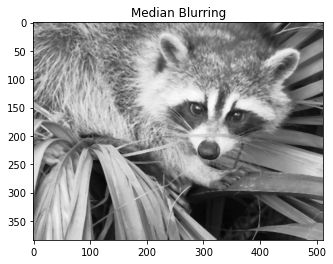

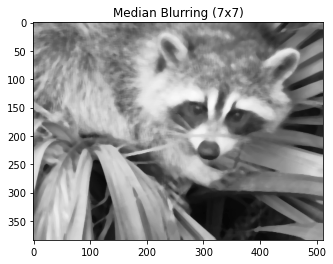

In [135]:
# Test Cases
gray_racoon = toGrayScale(racoon)
median_racoon = medianFilter(gray_racoon)
plt.imshow(median_racoon,cmap="Greys_r",vmin=0,vmax=255); plt.title("Median Blurring")
plt.show()

median_racoon2 = medianFilter(gray_racoon, 7)
plt.imshow(median_racoon2,cmap="Greys_r",vmin=0,vmax=255); plt.title("Median Blurring (7x7)")
plt.show()

## Function 8: General Convolution

Now that you have written a couple of different kernels, write a general convolution function that takes in an image and kernel (stored as a numpy matrix), and performs the appropriate convolution. You can assume the kernel is 3x3 if you would like, but it is not much harder to do a general size kernel as well.

In [140]:
def convolution(image,kernel):
    n_rows, n_cols = image.shape
    k_rows, k_cols = kernel.shape
    radius = int(k_rows//2)
    copied_matrix = image.copy()
    # Make a larger matrix with 0's for padding
    padded_matrix = np.zeros((n_rows+2,n_cols+2))
    padded_matrix[radius:n_rows+1, radius:n_cols+1] = copied_matrix
    for i in range(1, n_rows+1):
        for j in range(1, n_cols+1):
            top = i - radius
            bottom = i + radius + 1
            left = j - radius
            right = j + radius + 1
            temp = np.zeros((n_rows, n_cols))
            splice = padded_matrix[top:bottom, left:right]
            conv = np.multiply(splice, kernel)
            copied_matrix[i-radius,j-radius] = conv.sum()
    return copied_matrix

To make sure your general convolution is working, compare the following test case with your original blur results.

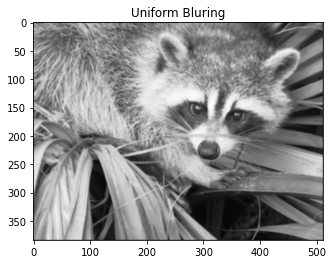

In [141]:
# Test Cases
gray_racoon = toGrayScale(racoon)

blur_kernel = np.matrix([[1, 1, 1],
                        [1, 1, 1],
                        [1, 1, 1]])

blur_racoon2 = convolution(gray_racoon, blur_kernel)/9.0
plt.imshow(blur_racoon2,cmap="Greys_r",vmin=0,vmax=255); plt.title("Uniform Bluring")
plt.show()

## Function 9: Sharpening
Takes in a grayscale image and returns a corresponding result that has been sharpened using an unsharp masking kernel that has a 6 in the middle and -1s for the four-connected neighbors. You can use your general convolution function. You can ignore the edge pixels. **Don't forget to normalize your results.**

In [151]:
def sharpen(image):
    kernel = np.matrix([[0,-1, 0],
                       [-1, 6, -1],
                       [0, -1, 0]])
    return convolution(image, kernel)/2 # Normalize by dividing by 2



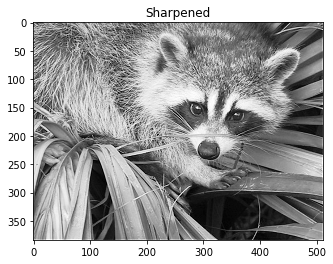

In [152]:
# Test Cases
gray_racoon = toGrayScale(racoon)
sharpen_racoon = sharpen(gray_racoon)
plt.imshow(sharpen_racoon,cmap="Greys_r",vmin=0,vmax=255); plt.title("Sharpened")
plt.show()

## Function 10: Edge Detection
Takes in a grayscale image and returns a corresponding result that shows the gradient magnitude of the input. Use a Sobel kernel. You may afterward scale the result for visibilty if you wish when you demonstrate the function. You can use your general convolution function. You can ignore the edge pixels.

In [205]:
def edgeDetect(image):
    sob_kernel_dy = np.matrix([[-1, -2, -1],
                               [0, 0, 0],
                               [1, 2, 1]])
    sob_kernel_dx = np.matrix([[-1,0,1],
                               [-2, 0, 2],
                               [-1, 0, 1]])
    image1 = convolution(image, sob_kernel_dy)
    image2 = convolution(image, sob_kernel_dx)
    # Find the magnatude
    final_image = (image1**2 + image2**2)**(.5)
    return final_image



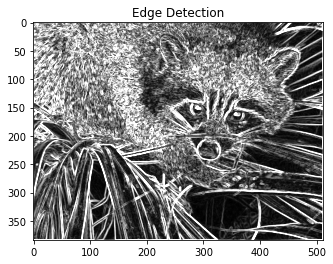

In [206]:
# Test Cases
gray_racoon = toGrayScale(racoon)
edge_racoon = edgeDetect(gray_racoon)
plt.imshow(edge_racoon,cmap="Greys_r",vmin=0,vmax=255); plt.title("Edge Detection")
plt.show()

------------------------------------------------HW #3-------------------------------------------------------------

In [ ]:
#1
np.matrix([[10, 11, 9, 25, 22],
           [8, 10, 9, 26, 28],
           [9, 99, 9, 24, 25],
           [11, 11, 12, 23, 22],
           [10, 11, 9, 22, 25]])

In [193]:
test = np.array([23,22,0,22,25,0,0,0,0])
assert(len(test) == 9)
np.median(test)


0.0

In [195]:
kernel = np.matrix([[1,2,1],
                    [2, 4, 2],
                    [1, 2, 1]])

image = np.matrix([[0,0,0,0,0],
                  [0,0,1,0,0],
                  [0,1,2,1,0],
                  [0,0,3,0,0],
                  [0,0,0,0,0]])
image1 = convolution(image, kernel)
image1

matrix([[ 0,  1,  2,  1,  0],
        [ 1,  6, 10,  6,  1],
        [ 2, 12, 20, 12,  2],
        [ 1, 10, 18, 10,  1],
        [ 0,  3,  6,  3,  0]])

In [199]:
image = np.matrix([[10,11,9,25,22],
                  [8,10,9,26,28],
                  [9,8,9,24,25],
                  [11,10,12,23,22],
                 [10,11,9,22,25]])

sharp_k = np.matrix([[0,-1, 0],
                    [-1, 5, -1],
                    [0, -1, 0]])
q = convolution(image, sharp_k)/2 # Normalize by dividing by 1
print(q)

[[15.5 13.   0.  34.  28.5]
 [ 5.5  7.  -4.5 22.  33.5]
 [ 9.   1.  -4.  18.5 25.5]
 [13.   4.   4.5 17.5 18.5]
 [14.  13.   0.  26.5 40.5]]


In [218]:
image = np.matrix([[10,11,9,25,22],
                  [8,10,9,26,28],
                  [9,8,9,24,25],
                  [11,10,12,23,22],
                 [10,11,9,22,25]])

print(edgeDetect(image))

TypeError: exponent must be an integer

In [213]:
import math


sob_kernel_dy = np.matrix([[-1, -2, -1],
                           [0, 0, 0],
                           [1, 2, 1]])

sob_kernel_dx = np.matrix([[-1,0,1],
                           [-2, 0, 2],
                           [-1, 0, 1]])

image1 = convolution(image, sob_kernel_dy)
print("image1dy:", image1)
image2 = convolution(image, sob_kernel_dx)
print("image2dx:", image2)
# Find the magnatude
final_image = (image1**2 + image2**2)**(.5)

# test = image1**2 + image2**2
# print(test)
# for i in range(test.shape[0]):
#     for j in range(test.shape[1]):
#         test[i,j] = math.sqrt(test[i,j])
# print(test)



image1dy: [[ 26  37  54  89  82]
 [ -5  -7  -4   1   5]
 [  6   6   3  -9 -15]
 [  5   7   1  -4  -2]
 [-32 -43 -57 -80 -67]]
image2dx: [[  32   -1   44   45  -76]
 [  39    1   62   67 -101]
 [  36    2   61   61  -97]
 [  39    1   53   52  -92]
 [  32   -1   35   42  -67]]


TypeError: exponent must be an integer